ZHAW, CAS MAIN, Module Deep Learning  
**Final Project Finn Stein & Severin Trösch, April 2020**

# Predicting Triathlon-Rankings: RankNet

In this notebook, we aim to predict the ranking of triathlon races using a *RankNet algorithm*. The ranker should learn on a dataset containing triathlon wordcup-results from 1989 to 2020.  

In the end, we want to compare the quality of this ranker to those of other ranking-algorithms (e.g. FCNN).  

So, let's go :-)

### Import libraries and data

We use a Keras-implementation of the RankNet algorithm: LambdaRankNN

In [0]:
## install lambda rank nn
!pip install LambdaRankNN

In [0]:
## import other modules
import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt
import seaborn

%tensorflow_version 1.x
#from keras import backend
#from keras.layers import Activation, Dense, Input, Subtract
#from keras.models import Model
from tensorflow.keras.utils import to_categorical, normalize 

from LambdaRankNN import LambdaRankNN

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
## have a look at the class
help(LambdaRankNN)

Help on class LambdaRankNN in module LambdaRankNN:

class LambdaRankNN(RankerNN)
 |  Method resolution order:
 |      LambdaRankNN
 |      RankerNN
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_size, hidden_layer_sizes=(100,), activation=('relu',), solver='adam')
 |      Parameters
 |      ----------
 |      input_size : integer
 |          Number of input features.
 |      hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 |          The ith element represents the number of neurons in the ith
 |          hidden layer.
 |      activation : tuple, length = n_layers - 2, default ('relu',)
 |          The ith element represents activation function in the ith
 |          hidden layer.
 |      solver : {'adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', adamax},
 |      default 'adam'
 |          The solver for weight optimization.
 |          - 'adam' refers to a stochastic gradient-based optimizer proposed
 |            by Kingma, Diede

In [0]:
## load data
df1 = pd.read_csv("/content/tri_data_nona_nodnf.csv", sep = ";",   encoding='latin-1')
df1

,subj_id,yob,age_y,nat,gender,race_id,race_venue,race_y,race_m,rank_num
0,2828,1990.0,30.0,SRB,Men,104,Chennai,2020,Feb,1
1,2864,1999.0,21.0,HKG,Men,104,Chennai,2020,Feb,2
2,816,1984.0,36.0,POL,Men,104,Chennai,2020,Feb,4
3,855,1999.0,21.0,KAZ,Men,104,Chennai,2020,Feb,5
4,1586,1997.0,23.0,HKG,Men,104,Chennai,2020,Feb,7
...,...,...,...,...,...,...,...,...,...,...
26036,2896,NaN,NaN,CAN,Women,1455,World,1989,Aug,6
26037,597,1966.0,23.0,CAN,Women,1455,World,1989,Aug,7
26038,3372,1964.0,25.0,GER,Women,1455,World,1989,Aug,8
26039,1964,NaN,NaN,CAN,Women,1455,World,1989,Aug,9


In [0]:
## get a data overview
df1.describe()

,subj_id,yob,age_y,race_id,race_y,rank_num
count,26041.000000,25081.000000,25081.000000,26041.000000,26041.000000,26041.000000
mean,1895.730079,1984.747578,26.054384,706.515687,2010.516301,18.110748
std,1136.906834,7.534797,4.342916,426.801280,5.893738,15.433225
min,1.000000,1957.000000,15.000000,1.000000,1989.000000,1.000000
25%,899.000000,1980.000000,23.000000,353.000000,2007.000000,6.000000
50%,1857.000000,1985.000000,26.000000,663.000000,2011.000000,12.000000
75%,2910.000000,1990.000000,29.000000,1075.000000,2015.000000,28.000000
max,3903.000000,2001.000000,50.000000,1489.000000,2020.000000,70.000000


In [0]:
## transform data (one-hot endoding of factorial variables)
# Get dummies
df1_d = pd.get_dummies(df1, prefix_sep='_', drop_first=True)
print(df1_d.head()) ## ATTENTION: subj_id must be character and thus one-hot encoded?! - this does not happen here, so I must do it manually (with to_categorical below)

   subj_id     yob  age_y  ...  race_m_Nov  race_m_Okt  race_m_Sep
0     2828  1990.0   30.0  ...           0           0           0
1     2864  1999.0   21.0  ...           0           0           0
2      816  1984.0   36.0  ...           0           0           0
3      855  1999.0   21.0  ...           0           0           0
4     1586  1997.0   23.0  ...           0           0           0

[5 rows x 347 columns]


In [0]:
df1_d #note: Many NaNs!

,subj_id,yob,age_y,race_id,race_y,rank_num,nat_ALG,nat_ARG,nat_ARU,nat_AUS,nat_AUT,nat_AZE,nat_BAR,nat_BEL,nat_BER,nat_BLR,nat_BOL,nat_BRA,nat_BRN,nat_CAN,nat_CHI,nat_CHN,nat_COK,nat_COL,nat_CRC,nat_CRO,nat_CUB,nat_CZE,nat_DEN,nat_DOM,nat_ECU,nat_EGY,nat_ENG,nat_ESA,nat_ESP,nat_EST,nat_FIN,nat_FRA,nat_GBR,nat_GEO,...,race_venue_SÃ¤ter,race_venue_Taizhou,race_venue_TiszaÃºjvÃ¡ros,race_venue_Tokyo,race_venue_Tongyeong,"race_venue_Toronto,",race_venue_Troutbeck,"race_venue_Tuscaloosa,",race_venue_Valencia,race_venue_Valle,race_venue_ValparaÃ­so,race_venue_Vancouver,race_venue_Varna,race_venue_Vienna,race_venue_ViÃ±a,"race_venue_Washington,",race_venue_Weert,race_venue_Weihai,race_venue_Weiswampach,race_venue_Wellington,"race_venue_Whistler,",race_venue_Wilkes,race_venue_World,race_venue_Yamaguichi,race_venue_Yicheng,race_venue_Yilan,race_venue_Yokohama,race_venue_Zhenjiang,race_venue_Zurich,race_m_Aug,race_m_Dez,race_m_Feb,race_m_Jan,race_m_Jul,race_m_Jun,race_m_Mai,race_m_MÃ¤r,race_m_Nov,race_m_Okt,race_m_Sep
0,2828,1990.0,30.0,104,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2864,1999.0,21.0,104,2020,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,816,1984.0,36.0,104,2020,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,855,1999.0,21.0,104,2020,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1586,1997.0,23.0,104,2020,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,2896,NaN,NaN,1455,1989,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
26037,597,1966.0,23.0,1455,1989,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
26038,3372,1964.0,25.0,1455,1989,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
26039,1964,NaN,NaN,1455,1989,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
## handle NaNs
df1_d.isnull().any() # there are nans - which is a problem for the net... if NaNs are present - models dont train!

# so fill the NaNs
df1_d_nona = df1_d.interpolate(method='linear', limit_direction='forward', axis=0)  # just brutely fill with 0s. better: df.interpolate(method='linear', limit_direction='forward', axis=0)  (instead of df.fillna(0))
df1_d_nona.isnull().any() # ok

subj_id        False
yob            False
age_y          False
race_id        False
race_y         False
               ...  
race_m_Mai     False
race_m_MÃ¤r    False
race_m_Nov     False
race_m_Okt     False
race_m_Sep     False
Length: 347, dtype: bool

In [0]:
## now transform to nparray
dat_n = df1_d_nona.values #this is the nparray-form of the data
print(dat_n.shape)
print(dat_n)

(26041, 347)
[[2828. 1990.   30. ...    0.    0.    0.]
 [2864. 1999.   21. ...    0.    0.    0.]
 [ 816. 1984.   36. ...    0.    0.    0.]
 ...
 [3372. 1964.   25. ...    0.    0.    0.]
 [1964. 1964.   25. ...    0.    0.    0.]
 [2238. 1964.   25. ...    0.    0.    0.]]


In [0]:
dat_n[:,5] # col 5 is the rank-column (Y)

array([ 1.,  2.,  4., ...,  8.,  9., 10.])

In [0]:
np.sum(np.isnan(dat_n)) # check number of nans

0

In [0]:
## now shuffle the data - for fair devision in train, val and test
np.random.seed(666)

dat_sh = copy.copy(dat_n)
np.random.shuffle(dat_sh) # --------------------------------------------------- try also skippin' the shuffeling! HERE BE DRAGONS!!!

dat_sh.shape

(26041, 347)

**Note:**

In the next step, I choose only *race_id_max* race-ids... Since if I taken more, the ranknet collapses (RAM explodes - even in colab!).

In [0]:
## filter a few race-ids for development...
# -------------------------------------------------------------------------------------------------- only use this cell during development - reduced data set!
race_id_max = 500 #how many race-ids to use (run cell above too when changing this)

cond = np.isin(dat_sh[:,3],[i+1 for i in range(race_id_max)]) #race-id is in 1:race_id_max
cond.shape
dat_sh = dat_sh[cond,:]
print(dat_sh.shape,' ... the new shape - for {} race ids'.format(race_id_max))
print()
print(dat_sh[:,3])

(10076, 347)  ... the new shape - for 500 race ids

[ 93. 207. 396. ... 252. 487. 216.]


In [0]:
## one-hot encode subj_id and race_id columns, as these are also categorical (but are not recognised as such by pd above)

subj_arr = to_categorical(dat_sh[:,0]) #subj_id column
print(subj_arr.shape)

race_arr = to_categorical(dat_sh[:,3]) #race_id column
print(race_arr.shape)

(10076, 3904)
(10076, 501)


In [0]:
## merge subj_id one-hot-matrix with rest of array

# first delete the old col
dat_n_0 = np.delete(dat_sh, [0,3,5], 1)  # delete first and the 4th column of dat_n (subj and race id), as well as the labels (col 5)

# then merge
np_n_1 = np.concatenate((dat_n_0, subj_arr, race_arr), axis=1)

print(dat_n.shape)
print(subj_arr.shape)
print(race_arr.shape)
print(np_n_1.shape) # seems correct - this is the one-hot encoded, non-normalised input data

(26041, 347)
(10076, 3904)
(10076, 501)
(10076, 4749)


In [0]:
## normalize the data
dat_sh_n = normalize(np_n_1)
#help(normalize)

In [0]:
## check - looks ok

print(dat_sh_n.shape)
print(dat_sh[:,1]) #yob
print(dat_sh_n[:,0]) #column with yob
print(np.nanmax(dat_sh[:,1])) #yob

(10076, 4749)
[1985. 1994. 1984. ... 1991. 1980. 1975.]
[0.7017441  0.70283889 0.70263808 ... 0.70211781 0.70137077 0.70189706]
2001.0


In [0]:
## and split X and Y - normalised and non-normalised

X = np_n_1 # the one-hot encoded inputs
Xnorm = dat_sh_n # the one-hot and normalised input-variables
Y = dat_sh[:,5] #the non-ohe-hot Y
Y_oh = to_categorical(dat_sh[:,5]) # col 5 is the rank-column (Y) - this is being one-hot encoded here


# check shapes
print(X.shape)
print(Xnorm.shape)
print(Y.shape)
print(Y_oh.shape)
print()

print(X)
print(Xnorm)
print()
print(Y)
print(Y_oh)

(10076, 4749)
(10076, 4749)
(10076,)
(10076, 71)

[[1985.   30. 2015. ...    0.    0.    0.]
 [1994.   24. 2018. ...    0.    0.    0.]
 [1984.   25. 2009. ...    0.    0.    0.]
 ...
 [1991.   28. 2019. ...    0.    0.    0.]
 [1980.   32. 2012. ...    0.    0.    0.]
 [1975.   29. 2004. ...    0.    0.    0.]]
[[0.7017441  0.0106057  0.7123498  ... 0.         0.         0.        ]
 [0.70283889 0.00845944 0.71129833 ... 0.         0.         0.        ]
 [0.70263808 0.00885381 0.71149189 ... 0.         0.         0.        ]
 ...
 [0.70211781 0.00987408 0.71199189 ... 0.         0.         0.        ]
 [0.70137077 0.01133529 0.71270606 ... 0.         0.         0.        ]
 [0.70189706 0.01030634 0.71220339 ... 0.         0.         0.        ]]

[37. 10. 15. ... 48. 27. 15.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
## generate train, val and test-set
X_val, X_test, X_train = X[0:1000], X[1000:2000], X[2000:]
Y_val, Y_test, Y_train = Y[0:1000], Y[1000:2000], Y[2000:]
Y_oh_val, Y_oh_test, Y_oh_train = Y_oh[0:1000], Y_oh[1000:2000], Y_oh[2000:]

# and for the normalsied data
X_val_norm, X_test_norm, X_train_norm = Xnorm[0:1000], Xnorm[1000:2000], Xnorm[2000:]

# check shapes
print(X_val.shape, X_test.shape, X_train.shape, ' ... the non-normalised inputs')
print(X_val_norm.shape, X_test_norm.shape, X_train_norm.shape,  ' ... the normalised inputs')
print()
print(Y_val.shape, Y_test.shape, Y_train.shape, ' ... the non-one-hot labels')
print(Y_oh_val.shape, Y_oh_test.shape, Y_oh_train.shape, ' ... the one-hot labels')

(1000, 4749) (1000, 4749) (8076, 4749)  ... the non-normalised inputs
(1000, 4749) (1000, 4749) (8076, 4749)  ... the normalised inputs

(1000,) (1000,) (8076,)  ... the non-one-hot labels
(1000, 71) (1000, 71) (8076, 71)  ... the one-hot labels


In [0]:
## what we'll need for the RankNet are these
print(X_train_norm, X_train_norm.shape) # the features
print()
print(Y_train, Y_train.shape) # the labels

[[0.70246819 0.00918721 0.7116554  ... 0.         0.         0.        ]
 [0.70157307 0.01094002 0.7125131  ... 0.         0.         0.        ]
 [0.70210015 0.00990867 0.71200882 ... 0.         0.         0.        ]
 ...
 [0.70211781 0.00987408 0.71199189 ... 0.         0.         0.        ]
 [0.70137077 0.01133529 0.71270606 ... 0.         0.         0.        ]
 [0.70189706 0.01030634 0.71220339 ... 0.         0.         0.        ]] (8076, 4749)

[20. 25. 20. ... 48. 27. 15.] (8076,)


In [0]:
## change dtype of labels (Y) - must be 'int' for the RankNet to work
Y_train_int = Y_train.astype('int')
Y_val_int = Y_val.astype('int')
Y_test_int = Y_test.astype('int')
Y_train_int.dtype

dtype('int64')

### Build and fit model

We now have generated and pre-processed tha dataset. So now, let's build a *RankNet*.

In [0]:
## define the "query-id" - for us, this is the race id (Query id that represents the grouping of samples.)
qid = dat_sh[2000:,3] # take only from 2000 onward - as in the training set

qid = qid.astype('int') # change dtype, must be 'int'
print(qid, qid.shape)

[300 370 247 ... 252 487 216] (8076,)


In [0]:
## check shapes and types again
print(X_train_norm.shape, type(X_train_norm), X_train_norm.dtype) # this must be float64
print(Y_train_int.shape, type(Y_train_int), Y_train_int.dtype) # this must be int64
print(qid.shape, type(qid), qid.dtype) # this must be int64

(8076, 4749) <class 'numpy.ndarray'> float64
(8076,) <class 'numpy.ndarray'> int64
(8076,) <class 'numpy.ndarray'> int64


In [0]:
## define model
ranker = LambdaRankNN(input_size = X_train_norm.shape[1], 
                      # here we define the hidden layers
                      hidden_layer_sizes= (128,64,32), 
                      activation=('relu', 'relu','relu'), 
                      solver='adam')

ranker.model.summary() # a RankNet model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer1 (InputLayer)       (None, 4749)         0                                            
__________________________________________________________________________________________________
Input_layer2 (InputLayer)       (None, 4749)         0                                            
__________________________________________________________________________________________________
relu_layer0 (Dense)             (None, 128)          608000      Input_layer1[0][0]               
                                                                 Input_layer2[0][0]               
__________________________________________________________________________________________________
relu_layer1 (Dense)             (None, 64)           8256        relu_layer0[0][0]          

In [0]:
## train model -- takes a while...
np.random.seed(11)
ranker.fit(X_train_norm, Y_train_int, qid, epochs = 20) #epochs = 20 in the end

/usr/local/lib/python3.6/dist-packages/LambdaRankNN/__init__.py:67: RuntimeWarning: overflow encountered in long_scalars
  sumdcg += ((2 ** rel) - 1) / math.log2(i + 2)
/usr/local/lib/python3.6/dist-packages/LambdaRankNN/__init__.py:287: RuntimeWarning: overflow encountered in long_scalars
  original = ((1 << pos_label) - 1) * pos_loginv + ((1 << neg_label) - 1) * neg_loginv
/usr/local/lib/python3.6/dist-packages/LambdaRankNN/__init__.py:288: RuntimeWarning: overflow encountered in long_scalars
  changed = ((1 << neg_label) - 1) * pos_loginv + ((1 << pos_label) - 1) * neg_loginv


Epoch 1/20
105101/105101 [==============================] - 35s 333us/step - loss: 0.0058
Epoch 2/20
105101/105101 [==============================] - 35s 330us/step - loss: 0.0058
Epoch 3/20
105101/105101 [==============================] - 35s 333us/step - loss: 0.0058
Epoch 4/20
105101/105101 [==============================] - 34s 323us/step - loss: 0.0058
Epoch 5/20
105101/105101 [==============================] - 34s 319us/step - loss: 0.0057
Epoch 6/20
105101/105101 [==============================] - 34s 324us/step - loss: 0.0057
Epoch 7/20
105101/105101 [==============================] - 34s 323us/step - loss: 0.0057
Epoch 8/20
105101/105101 [==============================] - 34s 322us/step - loss: 0.0057
Epoch 9/20
105101/105101 [==============================] - 33s 317us/step - loss: 0.0057
Epoch 10/20
105101/105101 [==============================] - 36s 347us/step - loss: 0.0057
Epoch 11/20
105101/105101 [==============================] - 34s 327us/step - loss: 0.0057
Epoch 12

### Try and evaluate the ranker

We use the *normalized discounted cumulative gain (NDCG)* to evaluate the ranking performance:

* https://en.wikipedia.org/wiki/Discounted_cumulative_gain
* https://towardsdatascience.com/evaluate-your-recommendation-engine-using-ndcg-759a851452d1

First, make a normal frediction and understand the output ...

In [0]:
## try and understand the prediction function
help(LambdaRankNN.predict) # ----- what is this? can this be ordered by?

Help on function predict in module LambdaRankNN:

predict(self, X)
    Predict output.
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Features.
    Returns
    -------
    y_pred: array, shape (n_samples,)
        Model prediction.



In [0]:
## layers
print(ranker.model.layers[-3])
ranker.model.layers

In [0]:
## make a prediction - fore one race id out of the dataset

# the input to make a prediction for:
raceid = 11 # cherrypicked ;-)

X_to_pred = X[dat_sh[:,3] == raceid,:] 
print(X_to_pred.shape)

# and the labels at same race id:
Y_true = Y[dat_sh[:,3] == raceid] 
print(Y_true.shape)
print()
print(Y_true)

(10, 4749)
(10,)

[ 4.  7.  6.  2.  5.  9. 10.  8.  3.  1.]


In [0]:
## predict (only makes sense within one qid! i.e. one race)
Y_pred = ranker.predict(X_to_pred) 
  # what does this prediction mean?! what is the unit? - 
  # it think this is the (unitless) prediction of the net (so the RELEVANCE SCORE of each item) which will be ordered by for the ranking...
  # note the large negative values of the relevance score
print(Y_pred[:5])
print(Y_pred.shape)

[-4598501. -4587965. -4593657. -4595172. -4595585.]
(10,)


Text(0.5, 1.0, 'Predicted vs. true ranks for race ID = 11')

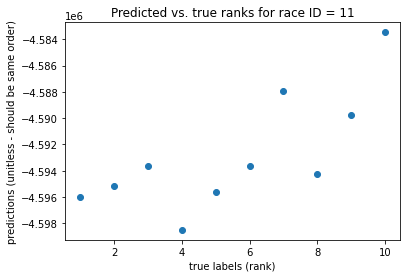

In [0]:
## plot the prediction - and compare the sorting to the labels (should correlate...)
plt.scatter(Y_true, Y_pred)
plt.ylabel("predictions (unitless - should be same order)")
plt.xlabel("true labels (rank)")
plt.title("Predicted vs. true ranks for race ID = {}".format(raceid))

Now, let's evaluate the performance of the whole ranker:

In [0]:
## understand the evaluate method
help(LambdaRankNN.evaluate)

Help on function evaluate in module LambdaRankNN:

evaluate(self, X, y, qid, eval_at=None)
    Predict and evaluate ndcg@eval_at.
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Features.
    y : array, shape (n_samples,)
        Target labels.
    qid: array, shape (n_samples,)
        Query id that represents the grouping of samples.
    eval_at: integer
        The rank postion to evaluate NDCG.
    Returns
    -------
    ndcg@eval_at: float



In [0]:
## evaluate training-performance: get the train NDCG
ranker.evaluate(X_train_norm, Y_train_int, qid, eval_at=None)

ndcg: 0.5623598873901552


In [0]:
## and finally, evaluate test-performance: get the test NDCG

# define qid for test set
qid_test = dat_sh[1000:2000,3] #  as in the test set
qid_test = qid_test.astype('int') # change dtype, must be 'int'

ranker.evaluate(X_test_norm, Y_test_int, qid_test, eval_at=None)

ndcg: 0.8289096375321607


### Comments / remaining questions:

* The test-NDCG of the model **for the shuffled data** is **0.83**. This is not much better than random... However, as we could use only n = 500 training races without crashing rhe RAM (see below), it is perhaps not surprising that the net does not perform better...?
* Why (just why!!!) is the test performance better than the training performance?! This, oddly, is only the case when the dataset is shuffled - if it is not shuffled, its the other way round...
* Again: The test performance of the ranker is clearly better than the training-performance... Why? Luck with the draw? Rather not - cause the same is true for the validation-data...
* We used 500 races for the training now - not all. This is, because the RAM collapses when we use more... The RankNet algorithm builds and compares every possible pair within one race and is therefore not very efficient.